In [13]:
import yaml
import pandas as pd
import time
import joblib
from backend.utils.data_preprocessor import DataPreprocessor
from sklearn.preprocessing import MinMaxScaler
import numpy as np

with open('../config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)

interval: str = config['feature_engineering']['time_series_interval']

training_file_path: str = f"../data/twelvedata/feature time series ({interval})/ABBV_feature_time_series.csv"
validation_file_path: str = f"../data/twelvedata/feature time series ({interval})/AAPL_feature_time_series.csv"

start_time = time.time()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

training_df = pd.read_csv(training_file_path)
validation_df = pd.read_csv(validation_file_path)


In [14]:
lookback_period: int = config['preprocess']['lookback_period']
target: str = config['preprocess']['target']
trend_length: int = config['preprocess']['trend_length']
training_preprocessor = DataPreprocessor(time_series=training_df, lookback_period=lookback_period, target=target, trend_length=trend_length)
validation_preprocessor = DataPreprocessor(time_series=validation_df, lookback_period=lookback_period, target=target, trend_length=trend_length)

X_train = training_preprocessor.feature_data_batched
y_train = training_preprocessor.label_data

X_val = validation_preprocessor.feature_data_batched
y_val = validation_preprocessor.label_data

training_preprocessor.target_data.head(50)

,open,high,low,close,volume,adx,atr,sma,ema,rsi,macd_signal,percent_b,open_(1_change),open_(1_change(%)),open_(1_trend),open_(2_change),open_(2_change(%)),open_(2_trend),open_(3_change),open_(3_change(%)),open_(3_trend),open_(4_change),open_(4_change(%)),open_(4_trend),open_(5_change),open_(5_change(%)),open_(5_trend),open_(6_change),open_(6_change(%)),open_(6_trend),open_(7_change),open_(7_change(%)),open_(7_trend),open_(8_change),open_(8_change(%)),open_(8_trend),open_(9_change),open_(9_change(%)),open_(9_trend),high_(1_change),high_(1_change(%)),high_(1_trend),high_(2_change),high_(2_change(%)),high_(2_trend),high_(3_change),high_(3_change(%)),high_(3_trend),high_(4_change),high_(4_change(%)),high_(4_trend),high_(5_change),high_(5_change(%)),high_(5_trend),high_(6_change),high_(6_change(%)),high_(6_trend),high_(7_change),high_(7_change(%)),high_(7_trend),high_(8_change),high_(8_change(%)),high_(8_trend),high_(9_change),high_(9_change(%)),high_(9_trend),low_(1_change),low_(1_change(%)),low_(1_trend),low_(2_change),low_(2_change(%)),low_(2_trend),low_(3_change),low_(3_change(%)),low_(3_trend),low_(4_change),low_(4_change(%)),low_(4_trend),low_(5_change),low_(5_change(%)),low_(5_trend),low_(6_change),low_(6_change(%)),low_(6_trend),low_(7_change),low_(7_change(%)),low_(7_trend),low_(8_change),low_(8_change(%)),low_(8_trend),low_(9_change),low_(9_change(%)),low_(9_trend),close_(1_change),close_(1_change(%)),close_(1_trend),close_(2_change),close_(2_change(%)),close_(2_trend),close_(3_change),close_(3_change(%)),close_(3_trend),close_(4_change),close_(4_change(%)),close_(4_trend),close_(5_change),close_(5_change(%)),close_(5_trend),close_(6_change),close_(6_change(%)),close_(6_trend),close_(7_change),close_(7_change(%)),close_(7_trend),close_(8_change),close_(8_change(%)),close_(8_trend),close_(9_change),close_(9_change(%)),close_(9_trend),sma_(1_change),sma_(1_change(%)),sma_(1_trend),sma_(2_change),sma_(2_change(%)),sma_(2_trend),sma_(3_change),sma_(3_change(%)),sma_(3_trend),sma_(4_change),sma_(4_change(%)),sma_(4_trend),sma_(5_change),sma_(5_change(%)),sma_(5_trend),sma_(6_change),sma_(6_change(%)),sma_(6_trend),sma_(7_change),sma_(7_change(%)),sma_(7_trend),sma_(8_change),sma_(8_change(%)),sma_(8_trend),sma_(9_change),sma_(9_change(%)),sma_(9_trend),ema_(1_change),ema_(1_change(%)),ema_(1_trend),ema_(2_change),ema_(2_change(%)),ema_(2_trend),ema_(3_change),ema_(3_change(%)),ema_(3_trend),ema_(4_change),ema_(4_change(%)),ema_(4_trend),ema_(5_change),ema_(5_change(%)),ema_(5_trend),ema_(6_change),ema_(6_change(%)),ema_(6_trend),ema_(7_change),ema_(7_change(%)),ema_(7_trend),ema_(8_change),ema_(8_change(%)),ema_(8_trend),ema_(9_change),ema_(9_change(%)),ema_(9_trend),rsi_(1_change),rsi_(1_change(%)),rsi_(1_trend),rsi_(2_change),rsi_(2_change(%)),rsi_(2_trend),rsi_(3_change),rsi_(3_change(%)),rsi_(3_trend),rsi_(4_change),rsi_(4_change(%)),rsi_(4_trend),rsi_(5_change),rsi_(5_change(%)),rsi_(5_trend),rsi_(6_change),rsi_(6_change(%)),rsi_(6_trend),rsi_(7_change),rsi_(7_change(%)),rsi_(7_trend),rsi_(8_change),rsi_(8_change(%)),rsi_(8_trend),rsi_(9_change),rsi_(9_change(%)),rsi_(9_trend),atr_(1_change),atr_(1_change(%)),atr_(1_trend),atr_(2_change),atr_(2_change(%)),atr_(2_trend),atr_(3_change),atr_(3_change(%)),atr_(3_trend),atr_(4_change),atr_(4_change(%)),atr_(4_trend),atr_(5_change),atr_(5_change(%)),atr_(5_trend),atr_(6_change),atr_(6_change(%)),atr_(6_trend),atr_(7_change),atr_(7_change(%)),atr_(7_trend),atr_(8_change),atr_(8_change(%)),atr_(8_trend),atr_(9_change),atr_(9_change(%)),atr_(9_trend),day,hour,target trend,label
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-15 12:30:00,109.98,110.33,109.88,110.06,419541,21.13,0.63,108.89,109.15,74.82,0.22,1.06,0.10,0.0910,1,0.69,0.6313,1,1.21,1.1124,1,1.59,1.4669,1,1.72,1.5888,1,1.8

In [15]:
X_train = X_train[:-training_preprocessor.trend_length]
y_train = y_train[:-training_preprocessor.trend_length]

X_val = X_val[:-validation_preprocessor.trend_length]
y_val = y_val[:-validation_preprocessor.trend_length]

X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])

end_time = time.time()
loading_time = end_time - start_time

print("Loading time: ", loading_time)
print("Training Dataset shape:", training_df.shape)
print("Validation Dataset shape:", validation_df.shape)
print("Training sets shape:", X_train.shape, y_train.shape)
print("Validation sets shape:", X_val.shape, y_val.shape)


Loading time:  2.3030850887298584
Training Dataset shape: (4970, 231)
Validation Dataset shape: (4970, 231)
Training sets shape: (4959, 9, 231) (4959,)
Validation sets shape: (4959, 9, 231) (4959,)


In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_filename: str = "scaler.save"
X_train_scaled_reshaped = scaler.fit_transform(X_train_reshaped)
X_val_scaled_reshaped = scaler.transform(X_val_reshaped)

joblib.dump(scaler, scaler_filename)

X_train_scaled = X_train_scaled_reshaped.reshape(X_train.shape)
X_val_scaled = X_val_scaled_reshaped.reshape(X_val.shape)

In [17]:
from backend.models.stock_trend_lstm_model import StockTrendLSTMModel

input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
epochs: int = config["model"]["epochs"]
batch_size: int = config["model"]["batch_size"]
my_model = StockTrendLSTMModel(input_shape, X_train_scaled, y_train, X_val_scaled, y_val, epochs, batch_size)
history = my_model.train()

Total number of weights in the model: 2061
Epoch 1/100
620/620 [==============================] - 15s 16ms/step - loss: 0.6481 - accuracy: 0.6324 - val_loss: 0.5929 - val_accuracy: 0.6991
Epoch 2/100
620/620 [==============================] - 9s 15ms/step - loss: 0.5718 - accuracy: 0.7096 - val_loss: 0.4916 - val_accuracy: 0.7746
Epoch 3/100
620/620 [==============================] - 8s 14ms/step - loss: 0.5008 - accuracy: 0.7667 - val_loss: 0.4366 - val_accuracy: 0.8147
Epoch 4/100
620/620 [==============================] - 8s 13ms/step - loss: 0.4675 - accuracy: 0.7913 - val_loss: 0.4205 - val_accuracy: 0.8254
Epoch 5/100
620/620 [==============================] - 8s 14ms/step - loss: 0.4621 - accuracy: 0.7992 - val_loss: 0.4165 - val_accuracy: 0.8278
Epoch 6/100
620/620 [==============================] - 8s 13ms/step - loss: 0.4588 - accuracy: 0.7990 - val_loss: 0.4140 - val_accuracy: 0.8298
Epoch 7/100
620/620 [==============================] - 8s 13ms/step - loss: 0.4547 - accurac

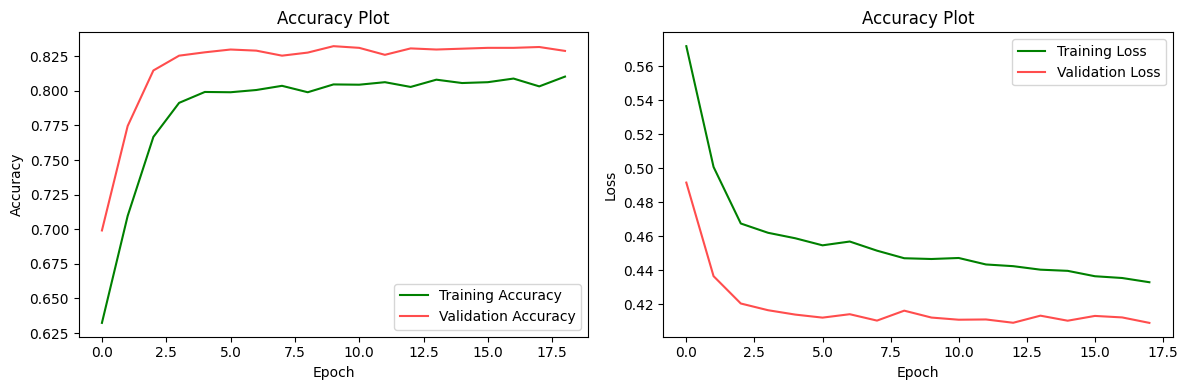

In [18]:
from backend.utils.visualizing_service import plot_model_accuracy
plot_model_accuracy(history)